INFO:__main__:Using device: cuda
0.0%

100.0%


Extracting VOC\VOCtrainval_06-Nov-2007.tar to VOC


C:\Users\K\PycharmProjects\I\.venv\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


down_ratio = 4
loss_dict = {}


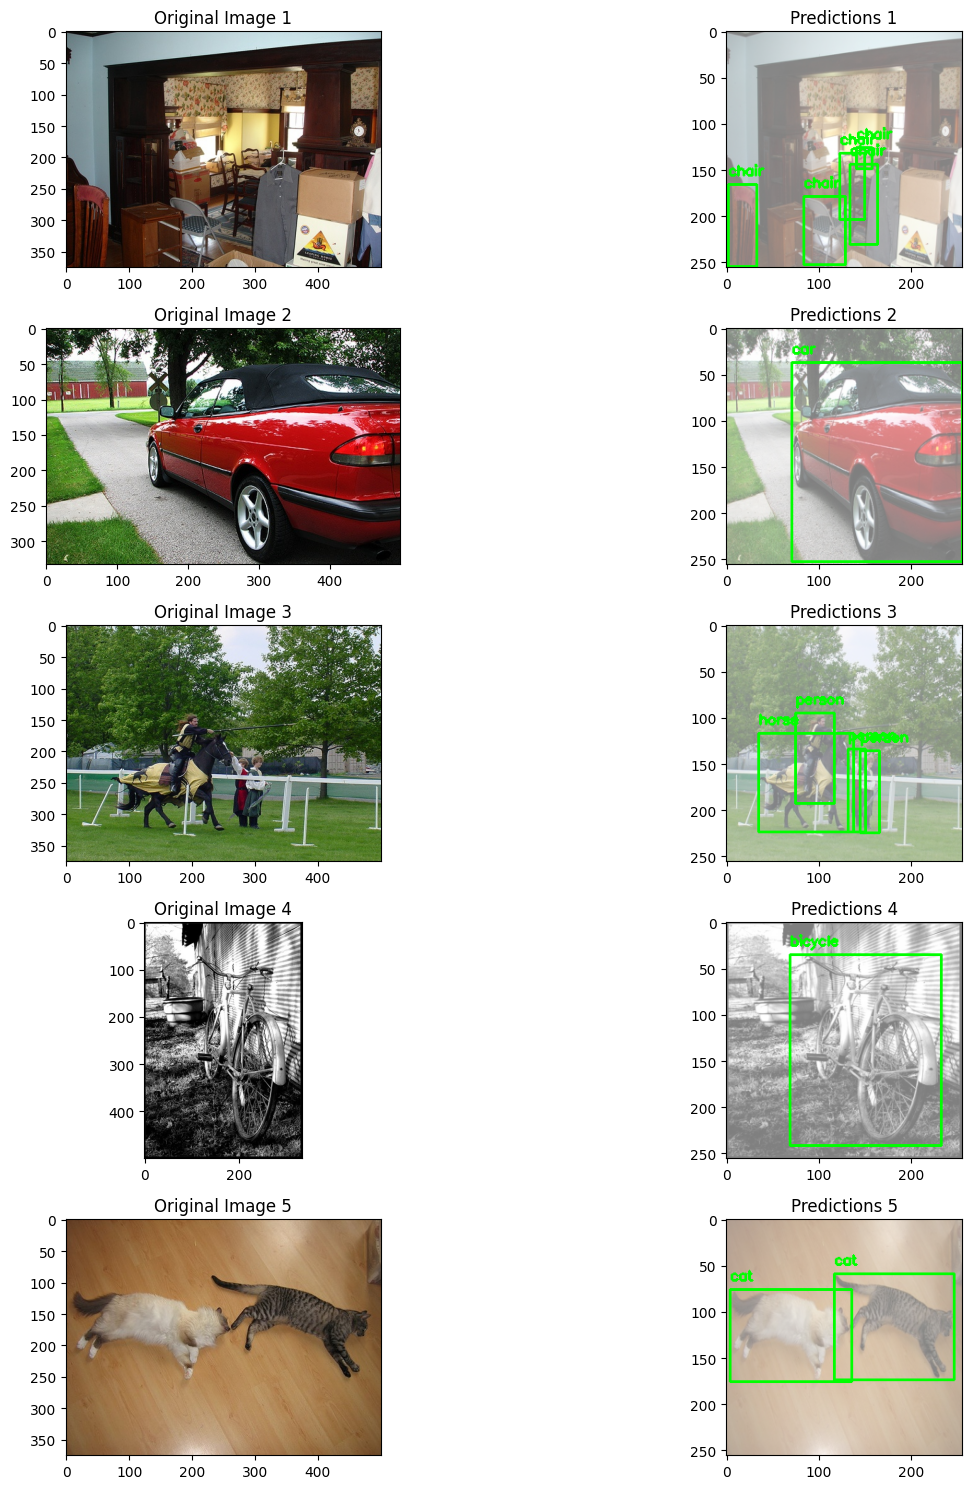

In [2]:
import os
import torch
import torchvision
from sympy import false
from torchvision.transforms import v2 as transforms
from torch.utils.data import Subset
import numpy as np
import matplotlib.pyplot as plt
import cv2
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Import custom modules
from training.encoder import CenternetEncoder
from postrprocess_visual.postprocess import CenternetPostprocess
from postrprocess_visual.visualizer import get_image_with_bboxes, PASCAL_CLASSES
from models.centernet import ModelBuilder

def prepare_dataset():
    """Prepare the validation dataset"""
    try:
        # Load VOC dataset
        dataset_val = torchvision.datasets.VOCDetection(root="VOC", year='2007', image_set="val", download=True)
        dataset_val = torchvision.datasets.wrap_dataset_for_transforms_v2(dataset_val)

        # Select first 30 indices for visualization
        indices = list(range(min(10, len(dataset_val))))
        dataset_val = Subset(dataset_val, indices)

        return dataset_val
    except Exception as e:
        logger.error(f"Error preparing dataset: {e}")
        raise

def create_transforms(input_height=256, input_width=256):
    """Create image transforms"""
    return transforms.Compose([
        transforms.Resize(size=(input_width, input_height)),
        transforms.ToTensor()
    ])

def load_trained_model(checkpoint_path, device):
    """Load the trained CenterNet model"""
    try:
        if not os.path.exists(checkpoint_path):
            raise FileNotFoundError(f"Checkpoint file not found: {checkpoint_path}")

        model = ModelBuilder(alpha=0.25).to(device)
        model.load_state_dict(torch.load(checkpoint_path, map_location=device, weights_only=True))
        model.eval()
        return model
    except Exception as e:
        logger.error(f"Error loading model: {e}")
        raise

def visualize_predictions(model, dataset, transform, encoder, postprocessor, device, num_samples=5, confidence_threshold=0.3):
    """Visualize model predictions"""
    plt.figure(figsize=(15, 3*num_samples))

    for i in range(min(num_samples, len(dataset))):
        # Get original image and ground truth
        orig_img, orig_label = dataset[i]

        # Apply transforms
        img, bboxes, labels = transform(orig_img, orig_label['boxes'], orig_label['labels'])
        img = img.unsqueeze(0).to(device)

        # Inference
        with torch.no_grad():
            pred = model(img)

        # Postprocess predictions
        detections = postprocessor(pred)

        # Convert to numpy for processing
        img_np = np.transpose(img.cpu().squeeze().numpy(), (1, 2, 0))
        img_np = (img_np * 0.5) + 0.5  # Denormalize
        img_np = np.clip(img_np, 0, 1)

        # Reconstruct bounding boxes
        img_h, img_w = img_np.shape[:2]
        pred_boxes = []
        pred_labels = []

        for det in detections[0]:
            class_id = int(det[0].item())
            score = det[1].item()

            # Only process detections with reasonable confidence
            if score > confidence_threshold:
                x1 = int(det[2].item() * img_w)
                y1 = int(det[3].item() * img_h)
                x2 = int(det[4].item() * img_w)
                y2 = int(det[5].item() * img_h)

                pred_boxes.append([x1, y1, x2, y2])
                pred_labels.append(class_id)

        # Visualize
        plt.subplot(num_samples, 2, 2*i+1)
        plt.title(f'Original Image {i+1}')
        plt.imshow(orig_img)

        plt.subplot(num_samples, 2, 2*i+2)
        plt.title(f'Predictions {i+1}')
        img_with_pred = img_np.copy()

        # Draw predicted bounding boxes
        for box, label in zip(pred_boxes, pred_labels):
            cv2.rectangle(img_with_pred,
                          (box[0], box[1]),
                          (box[2], box[3]),
                          (0, 255, 0), 2)
            # Add class label
            cv2.putText(img_with_pred,
                        PASCAL_CLASSES[label-1],
                        (box[0], box[1]-10),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, (0, 255, 0), 2)

        plt.imshow(img_with_pred)

    plt.tight_layout()
    plt.show()

def main():
    try:
        # Device configuration
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        logger.info(f"Using device: {device}")

        # Hyperparameters
        input_height = input_width = 256
        down_ratio = 4
        checkpoint_path = 'C:/Users/K/PycharmProjects/object_detection/models/checkpoints/pretrained_weights.pt'

        # Prepare components
        dataset = prepare_dataset()
        transform = create_transforms(input_height, input_width)
        encoder = CenternetEncoder(input_height, input_width)
        postprocessor = CenternetPostprocess(n_classes=20, width=input_width, height=input_height, down_ratio=down_ratio).to(device)

        # Load trained model
        model = load_trained_model(checkpoint_path, device)

        # Visualize predictions
        visualize_predictions(model, dataset, transform, encoder, postprocessor, device)

    except Exception as e:
        logger.error(f"An error occurred: {e}")

if __name__ == "__main__":
    main()